<a href="https://colab.research.google.com/github/fabianfoos/RedesNeuronales/blob/main/UTN_FRP_NN_Practica4_prePandemi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://www.frp.utn.edu.ar/info2/wp-content/uploads/2018/03/utn-parana.png" alt="UTN-FRP"/>

<h1>Maestría en Minería de Datos</h1>
<h2>Redes neuronales: Práctica 4</h2>
<h3>Estudiantes: ...</h2>

# Configuración inicial

Importar las librerías necesarias y configurar el entorno.


In [1]:
from datetime import datetime

import keras
import numpy as np
import yfinance as yf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, GRU, LSTM

# Descarga y análisis de datos
En este problema construiremos un modelo que genere predicciones respecto de un activo financiero. El activo que estaremos usando es el precio de cierre de la acción de YPF en la Bolsa de Comercio de Buenos Aires, y se pretende que el modelo sea capaz de generar la predicción del precio del cierre al comenzar ese mismo día.

**Disclaimer**: *El equipo docente no recomienda, bajo ningún punto de vista, la utilización de este instrumento financiero ni de cualquier otro activo similar como elemento de inversión y/o ahorro. El uso de estos datos tiene fines puramente académicos y busca ser un medio para el aprendizaje y la aplicación de los temas vistos en este curso.*

In [2]:
# Descarga de datos históricos
ticker_symbol = "YPFD.BA"
start_date = "2015-01-01"
end_date = "2019-12-31"
ypf_data = yf.download(ticker_symbol, start=start_date, end=end_date)

close_prices = ypf_data['Close'].values.reshape(-1, 1)

def create_sequences(data, window_size):
    sequences = []
    targets = []
    for i in range(len(data) - window_size):
        sequences.append(data[i:i + window_size])
        targets.append(data[i + window_size])
    return np.array(sequences), np.array(targets)

/tmp/ipython-input-2099794188.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  ypf_data = yf.download(ticker_symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


## Análisis descriptivo de los datos

Realice un primer análisis para entender el comportamiento de la serie temporal que utilizaremos en este problema. Evalúe si existen valores nulos, si la serie de datos presenta estacionalidad, tendencia, etc.

Observaciones totales (incluyendo nulos): 1221
Rango de fechas:  2015-01-02 00:00:00 a 2019-12-30 00:00:00

Valores nulos por columna:
Price  Ticker 
Close  YPFD.BA    0
dtype: int64

Estadísticos descriptivos de Close:
Ticker      YPFD.BA
count   1221.000000
mean     410.624734
std      152.916419
min      173.544662
25%      285.039856
50%      362.071167
75%      523.137756
max      873.750000


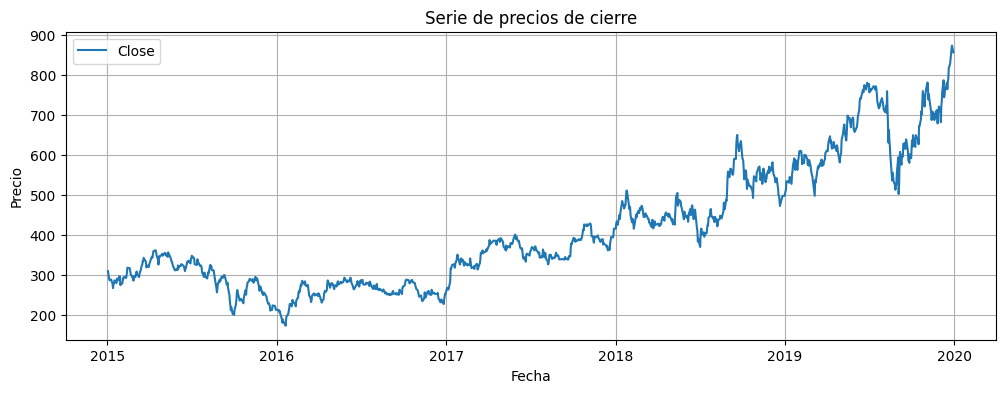

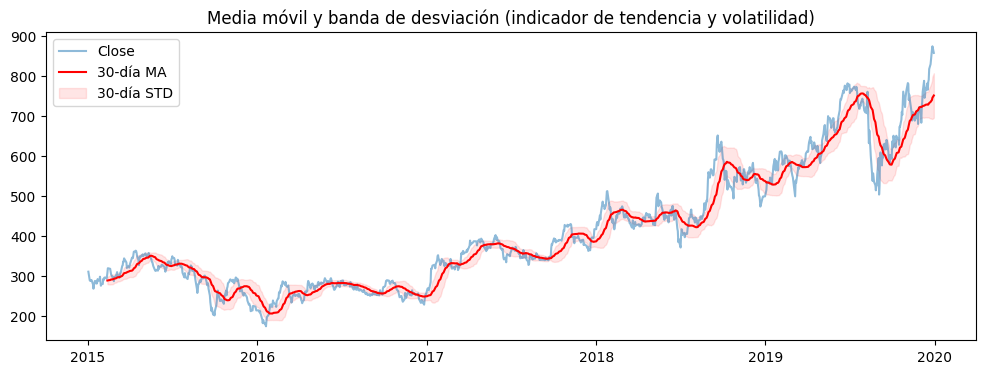

Usando periodo=252 para descomposición estacional (si procede)


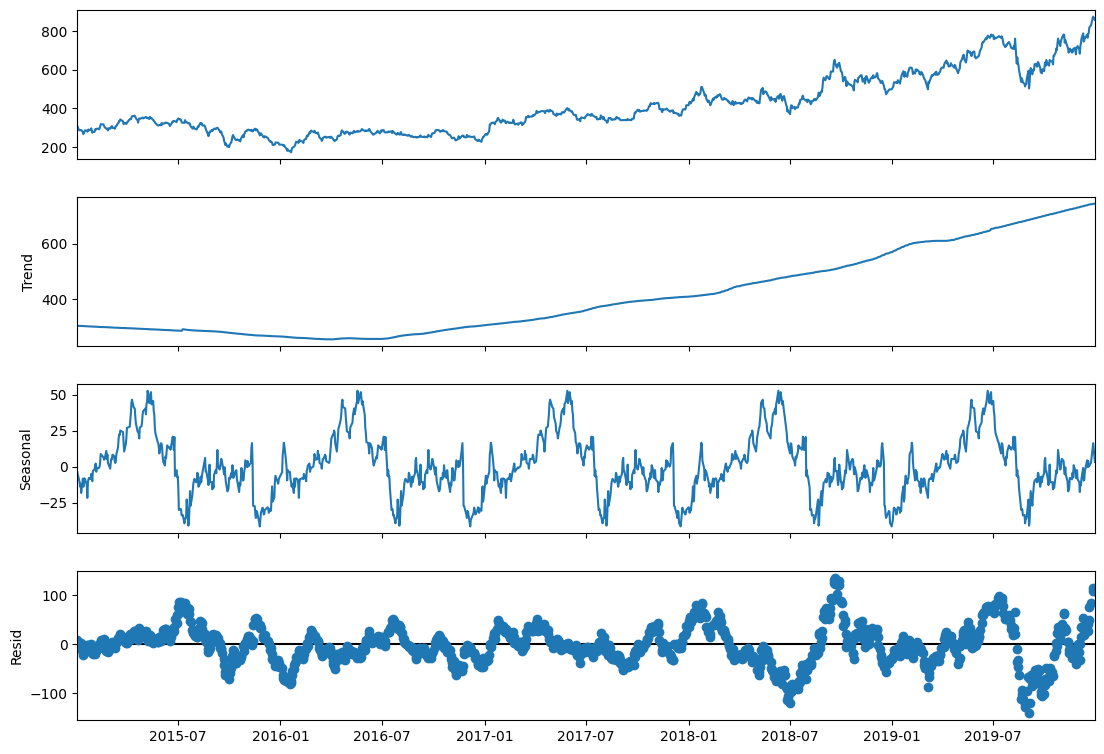


--- Prueba ADF sobre la serie de precios ---
ADF statistic: 0.26062838891612644
p-value: 0.9754642553368303
Valores críticos: {'1%': np.float64(-3.435806562661181), '5%': np.float64(-2.8639495363486884), '10%': np.float64(-2.56805288000355)}

Estadísticos de retornos (pct_change):
Ticker      YPFD.BA
count   1220.000000
mean       0.001184
std        0.026421
min       -0.169145
25%       -0.014251
50%        0.000000
75%        0.015337
max        0.118462

--- Prueba ADF sobre retornos ---
ADF statistic (returns): -34.641685072793436
p-value (returns): 0.0
Valores críticos (returns): {'1%': np.float64(-3.4357258193266365), '5%': np.float64(-2.863913913276725), '10%': np.float64(-2.5680339084067483)}


<Figure size 1200x400 with 0 Axes>

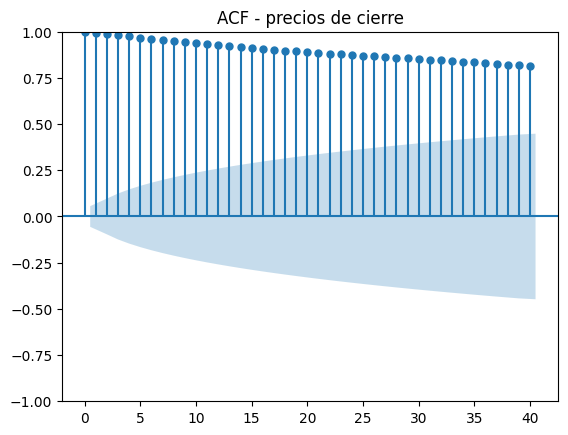

<Figure size 1200x400 with 0 Axes>

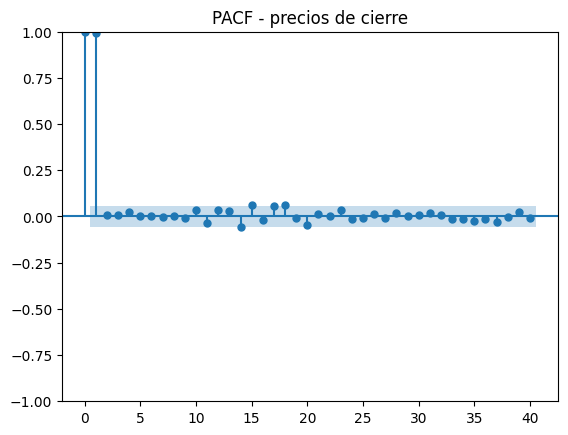

<Figure size 1200x400 with 0 Axes>

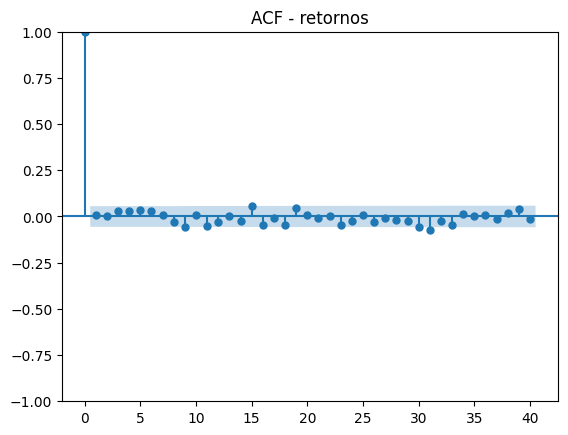

<Figure size 1200x400 with 0 Axes>

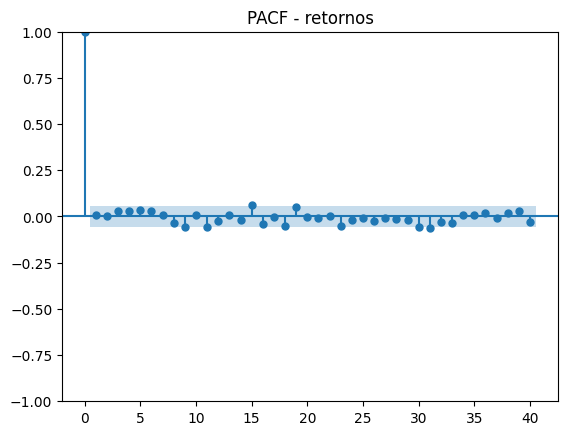


EDA summary: {'n_obs': 1221, 'start': '2015-01-02 00:00:00', 'end': '2019-12-30 00:00:00', 'n_nulls': 0, 'adf_pvalue_series': 0.9754642553368303, 'adf_pvalue_returns': 0.0}


/tmp/ipython-input-83388592.py:133: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  'n_nulls': int(df['Close'].isna().sum()),


In [3]:
# Análisis exploratorio inicial de la serie de precios de cierre
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Preparar serie con índice datetime
if 'ypf_data' in globals():
    df = ypf_data.copy()
else:
    # si no existe ypf_data, intentar reconstruir desde close_prices
    df = pd.DataFrame(close_prices, columns=['Close'])
    try:
        df.index = pd.to_datetime(ypf_data.index)
    except Exception:
        pass

# Asegurar datetime index y eliminar nulos
if not isinstance(df.index, pd.DatetimeIndex):
    df = df.reset_index()
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'])
        df = df.set_index('Date')

df = df[['Close']].copy()
print('Observaciones totales (incluyendo nulos):', len(df))
print('Rango de fechas: ', df.index.min(), 'a', df.index.max())
print('\nValores nulos por columna:')
print(df.isna().sum())

# Estadísticos básicos
print('\nEstadísticos descriptivos de Close:')
print(df['Close'].describe())

# Visualización de la serie
plt.figure(figsize=(12,4))
plt.plot(df['Close'], label='Close')
plt.title('Serie de precios de cierre')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.grid(True)
plt.legend()
plt.show()

# Rolling mean / std para observar tendencia y volatilidad
window = 30
rolling_mean = df['Close'].rolling(window=window).mean()
rolling_std = df['Close'].rolling(window=window).std()

# Asegurar arrays 1D para matplotlib.fill_between
x = df.index.to_numpy()
close_vals = df['Close'].to_numpy().ravel()
ma_vals = rolling_mean.to_numpy().ravel()
lower = (rolling_mean - rolling_std).to_numpy().ravel()
upper = (rolling_mean + rolling_std).to_numpy().ravel()

plt.figure(figsize=(12,4))
plt.plot(x, close_vals, alpha=0.5, label='Close')
plt.plot(x, ma_vals, color='red', label=f'{window}-día MA')
plt.fill_between(x, lower, upper, color='red', alpha=0.1, label=f'{window}-día STD')
plt.title('Media móvil y banda de desviación (indicador de tendencia y volatilidad)')
plt.legend()
plt.show()

# Determinar periodo para descomposición: si hay >=252 observaciones probaremos anual, si no usaremos 5 (semanal)
period = 252 if len(df) >= 252 else 5
print(f'Usando periodo={period} para descomposición estacional (si procede)')

# Descomposición estacional (try seasonal_decompose, si falla probar STL)
try:
    res = seasonal_decompose(df['Close'].dropna(), period=period, model='additive', extrapolate_trend='freq')
    fig = res.plot()
    fig.set_size_inches(12,8)
    plt.show()
except Exception as e:
    print('seasonal_decompose falló:', e)
    try:
        stl = STL(df['Close'].dropna(), period=period)
        res2 = stl.fit()
        fig = res2.plot()
        fig.set_size_inches(12,8)
        plt.show()
    except Exception as e2:
        print('STL falló:', e2)

# Test de estacionariedad ADF sobre la serie original y sobre retornos
series = df['Close'].dropna()
print('\n--- Prueba ADF sobre la serie de precios ---')
adf_res = adfuller(series)
print('ADF statistic:', adf_res[0])
print('p-value:', adf_res[1])
print('Valores críticos:', adf_res[4])

# Calcular retornos simples y su estacionariedad
returns = series.pct_change().dropna()
print('\nEstadísticos de retornos (pct_change):')
print(returns.describe())

print('\n--- Prueba ADF sobre retornos ---')
adf_ret = adfuller(returns)
print('ADF statistic (returns):', adf_ret[0])
print('p-value (returns):', adf_ret[1])
print('Valores críticos (returns):', adf_ret[4])

# ACF / PACF para la serie y para retornos
plt.figure(figsize=(12,4))
plot_acf(series, lags=40)
plt.title('ACF - precios de cierre')
plt.show()

plt.figure(figsize=(12,4))
plot_pacf(series, lags=40, method='ywm')
plt.title('PACF - precios de cierre')
plt.show()

plt.figure(figsize=(12,4))
plot_acf(returns, lags=40)
plt.title('ACF - retornos')
plt.show()

plt.figure(figsize=(12,4))
plot_pacf(returns, lags=40, method='ywm')
plt.title('PACF - retornos')
plt.show()

# Guardar resultados básicos para la conclusión posterior
eda_summary = {
    'n_obs': int(len(df)),
    'start': str(df.index.min()),
    'end': str(df.index.max()),
    'n_nulls': int(df['Close'].isna().sum()),
    'adf_pvalue_series': float(adf_res[1]),
    'adf_pvalue_returns': float(adf_ret[1])
}
print('\nEDA summary:', eda_summary)


In [4]:
# Cálculo numérico rápido: ADF y estadísticas clave (sin gráficos)
from statsmodels.tsa.stattools import adfuller
import numpy as np

# Recolectar la serie de cierre y asegurar 1D Series
if 'ypf_data' in globals():
    series = ypf_data['Close'].dropna()
    # si devuelve DataFrame con una sola columna, convertir a Series
    if isinstance(series, (pd.DataFrame,)):
        series = series.iloc[:, 0]
    series = series.astype(float)
else:
    raise RuntimeError('No se encontró `ypf_data`. Ejecutar la celda de descarga primero.')

n_obs = len(series)
start = series.index.min()
end = series.index.max()
n_nulls = int(series.isna().sum())

# Estadísticos básicos
desc = series.describe()

# ADF test on levels
adf_levels = adfuller(series)
adf_levels_stat = float(adf_levels[0])
adf_levels_p = float(adf_levels[1])

# ADF on returns
returns = series.pct_change().dropna()
adf_ret = adfuller(returns)
adf_ret_stat = float(adf_ret[0])
adf_ret_p = float(adf_ret[1])

# Autocorrelaciones de retornos primeras 5 lags
autocorrs = [returns.autocorr(lag=i) for i in range(1,6)]

print('Resumen numérico EDA:')
print('Observaciones:', n_obs)
print('Rango de fechas:', start, 'a', end)
print('Valores nulos en Close:', n_nulls)
print('\nEstadísticos Close:')
print(desc)
print('\nADF (niveles) statistic =', adf_levels_stat, ', p-value =', adf_levels_p)
print('ADF (retornos) statistic =', adf_ret_stat, ', p-value =', adf_ret_p)
print('\nAutocorrelaciones retornos (lags 1..5):', np.round(autocorrs, 4))

# Guardar resultados simples
eda_numeric_summary = {
    'n_obs': int(n_obs),
    'start': str(start),
    'end': str(end),
    'n_nulls': int(n_nulls),
    'adf_levels_p': adf_levels_p,
    'adf_returns_p': adf_ret_p,
    'returns_autocorr_lag1': float(autocorrs[0])
}

print('\nEDA numeric summary saved to `eda_numeric_summary`')


Resumen numérico EDA:
Observaciones: 1221
Rango de fechas: 2015-01-02 00:00:00 a 2019-12-30 00:00:00
Valores nulos en Close: 0

Estadísticos Close:
count    1221.000000
mean      410.624734
std       152.916419
min       173.544662
25%       285.039856
50%       362.071167
75%       523.137756
max       873.750000
Name: YPFD.BA, dtype: float64

ADF (niveles) statistic = 0.26062838891612644 , p-value = 0.9754642553368303
ADF (retornos) statistic = -34.641685072793436 , p-value = 0.0

Autocorrelaciones retornos (lags 1..5): [0.0098 0.0024 0.0315 0.0281 0.0342]

EDA numeric summary saved to `eda_numeric_summary`


## Construcción de una línea de base

La generación de una línea de base es un buen primer paso para resolver muchos problemas que requieren trabajar con datos. Una línea de base es cualquier modelo simple que podemos construir con muy poco tiempo/trabajo, y que usualmente no requiere de la utilización de modelos de aprendizaje automático. Por ejemplo, una línea de base extremadamente simple para cualquier problema es devolver un valor aleatorio. Para el problema que trabajeremos en este práctico, podemos pensar alguna línea de base que nos permita principalmente establecer una cota inferior del rendimiento esperado del modelo. Dicho con otras palabras, si un modelo no es capaz de superar el rendimiento de una mera función en Python que implemente una estrategia o predicción simple, entonces podríamos pensar que nuestro modelo de aprendizaje automático no ha tenido éxito.

Proponga una línea de base determinada y analice el resultado obtenido para un período de tiempo en concreto. Asuma que la información disponible estará determinada por todo dato que se encuentre disponible al momento de la apertura de mercado en el día que se intenta predecir. A modo de ejemplo, un dato que no podría utilizarse para predecir el valor del precio de cierre del día 10 de diciembre de 2025 es el volumen, dado que representa la cantidad de operaciones realizadas a lo largo de todo el día.

### Línea de base: predicción ingenua

Se implementa una línea de base que predice el precio de cierre de hoy usando el precio de cierre de ayer (naive forecast). Esta estrategia es común en series temporales financieras y sirve como referencia mínima: cualquier modelo más complejo debería superar este desempeño. Se reporta el error porcentual medio absoluto (MAPE) y se grafican los valores reales vs. predichos.

In [5]:
# Línea de base: predicción ingenua (naive forecast)
def baseline(df_prices):
    """
    Predice el precio de cierre de hoy usando el precio de cierre de ayer (naive forecast).
    Devuelve el MAPE y un DataFrame con reales y predichos.
    """
    series = df_prices['Close'].dropna()
    y_true = series[1:].to_numpy().ravel()  # desde el segundo día
    y_pred = series[:-1].to_numpy().ravel()  # hasta el penúltimo día
    fechas = series.index[1:]
    fechas = pd.to_datetime(fechas).to_numpy()
    mape = mean_absolute_percentage_error(y_true, y_pred)
    resultados = pd.DataFrame({'Fecha': fechas, 'Real': y_true, 'Predicción': y_pred})
    return mape, resultados


MAPE baseline (naive forecast): 0.0196


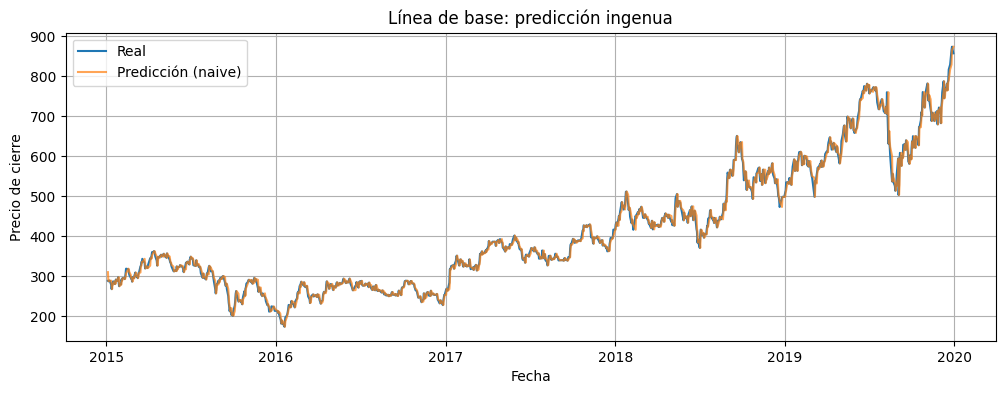

In [6]:
# Evaluar baseline sobre todo el período disponible
def run_and_plot_baseline():
    mape, resultados = baseline(ypf_data)
    print(f"MAPE baseline (naive forecast): {mape:.4f}")
    # Graficar reales vs predicción
    plt.figure(figsize=(12,4))
    plt.plot(resultados['Fecha'], resultados['Real'], label='Real')
    plt.plot(resultados['Fecha'], resultados['Predicción'], label='Predicción (naive)', alpha=0.7)
    plt.title('Línea de base: predicción ingenua')
    plt.xlabel('Fecha')
    plt.ylabel('Precio de cierre')
    plt.legend()
    plt.grid(True)
    plt.show()
    return mape, resultados

# Ejecutar baseline y mostrar resultados
baseline_mape, baseline_resultados = run_and_plot_baseline()


# Análisis de pesos de una red recurrente simple

Cree una arquitectura de red neuronal recurrente tradicional utilizando para cada ejemplo de entrenamiento una secuencia de largo 40 y 25 unidades, y una única neurona de salida. Sin entrenar dicho modelo, evalúe la estructura de los pesos de dicha red (utilice como ayuda los métodos get_weights y summary). A qué corresponde cada dimensión de la estructura de pesos devuelta?


In [7]:
# Define a function to create the RNN model
from tensorflow.keras import Input

def create_rnn_model(units, input_shape, layer_class):
    """
    Crea una red recurrente simple seguida de una capa densa de salida.
    - units: número de unidades en la capa recurrente
    - input_shape: (sequence_length, n_features)
    - layer_class: clase recurrente a usar (SimpleRNN, GRU, LSTM)
    """
    model = Sequential()
    model.add(Input(shape=input_shape))
    # Capa recurrente: no devolver secuencias (return_sequences=False)
    model.add(layer_class(units, return_sequences=False))
    # Salida: una neurona (regresión del precio)
    model.add(Dense(1, name='output'))

    loss_function = 'mse'
    model.compile(optimizer='adam', loss=loss_function)
    return model


In [8]:
# Construir un modelo RNN sin entrenar y examinar la estructura de pesos
seq_len = 40
units = 25

# Crear el modelo (se asume entrada univariante -> n_features=1)
model_rnn = create_rnn_model(units, (seq_len, 1), SimpleRNN)

print('\n--- Modelo RNN (sin entrenar) ---')
model_rnn.summary()

# Mostrar pesos por capa y sus shapes
print('\n--- Pesos por capa (get_weights) ---')
for layer in model_rnn.layers:
    w = layer.get_weights()
    print(f"Capa: {layer.name} - tipo: {layer.__class__.__name__}")
    if not w:
        print('  No tiene pesos (p. ej. una capa de activación sin parámetros).')
        continue
    for i, arr in enumerate(w):
        print(f"  peso[{i}] shape = {arr.shape}")

# Interpretación de las formas (explicación):
print('\n--- Interpretación de las matrices de pesos ---')
print('Para la capa SimpleRNN (primera capa) Keras mantiene 3 matrices:')
print('  1) kernel: forma (input_dim, units) -> pesos que conectan la entrada a las unidades recurrentes')
print('  2) recurrent_kernel: forma (units, units) -> pesos de la conexión recurrente entre unidades')
print('  3) bias: forma (units,) -> sesgos para cada unidad')
print(f"  En nuestro caso, input_dim=1, units={units} => kernel (1,{units}), recurrent_kernel ({units},{units}), bias ({units},)")
print('\nPara la capa Dense(1) final Keras mantiene:')
print('  1) kernel: forma (units, 1) -> conecta las unidades recurrentes a la salida')
print('  2) bias: forma (1,) -> sesgo de la salida')
print(f"  En nuestro caso: kernel ({units},1), bias (1,)")



--- Modelo RNN (sin entrenar) ---


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 25)             │           675 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 701 (2.74 KB)

 Trainable params: 701 (2.74 KB)

 Non-trainable params: 0 (0.00 B)


--- Pesos por capa (get_weights) ---
Capa: simple_rnn - tipo: SimpleRNN
  peso[0] shape = (1, 25)
  peso[1] shape = (25, 25)
  peso[2] shape = (25,)
Capa: output - tipo: Dense
  peso[0] shape = (25, 1)
  peso[1] shape = (1,)

--- Interpretación de las matrices de pesos ---
Para la capa SimpleRNN (primera capa) Keras mantiene 3 matrices:
  1) kernel: forma (input_dim, units) -> pesos que conectan la entrada a las unidades recurrentes
  2) recurrent_kernel: forma (units, units) -> pesos de la conexión recurrente entre unidades
  3) bias: forma (units,) -> sesgos para cada unidad
  En nuestro caso, input_dim=1, units=25 => kernel (1,25), recurrent_kernel (25,25), bias (25,)

Para la capa Dense(1) final Keras mantiene:
  1) kernel: forma (units, 1) -> conecta las unidades recurrentes a la salida
  2) bias: forma (1,) -> sesgo de la salida
  En nuestro caso: kernel (25,1), bias (1,)


# Experimentación

Proponga y analice distintas arquitecturas de redes neuronales recurrentes (simple, GRU y LSTM) variando la cantidad de unidades en cada caso y el largo de las secuencias de entrenamiento. Proponga un valor razonable para los hiper-parámetros de épocas de entrenamiento, tamaño del batch y proporción de casos en el conjunto de validación. Seleccione una función de costo y una métrica para evaluar los resultados, ambas acordes a este problema. Evaluar si algunas combinaciones genera sobre-entrenamiento podría ser útil para guiar la búsqueda/selección de hiper-parámetros.

Complete la función "evaluate_model" para que realice el entrenamiento de un modelo dado. Tenga presente que en este problema el modelo nunca debería ver en el conjunto de entrenamiento datos posteriores a los que se analicen en el período de evaluación/test.

Concluya sobre qué modelo obtuvo un mejor desempeño y, en caso de ser posible, analice qué combinación de hiper-parámetros suele dar mejores resultados. Considere en dicho análisis la cantidad de pesos de cada modelo y cómo este aspecto podría ayudar o interferir en el aprendizaje del mismo de acuerdo a la cantidad de datos disponibles en este problema. Analice la cantidad de parámetros de dicho modelo respecto a los analizados en el punto anterior.

In [9]:
def evaluate_model(model,
                   prices,
                   window_size,
                   epochs=50,
                   batch_size=32,
                   validation_split=0.2):
    """
    Entrena y evalúa un modelo de series temporales sin fuga temporal.
    - `prices`: array-like con shape (n_samples, 1) o pandas Series
    - `window_size`: largo de la secuencia (int)
    - `validation_split`: proporción final de datos usada como validación (por ejemplo 0.2)

    Devuelve: (history, metrics_dict, y_true_vs_pred)
    """
    import numpy as np
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error

    # Crear secuencias (X shape: (N, window_size, 1), y shape: (N,1))
    X, y = create_sequences(prices, window_size)
    if len(X) == 0:
        raise ValueError('window_size demasiado grande para la serie proporcionada')

    # División temporal: primeros datos -> entrenamiento, últimos -> validación
    split_idx = int(len(X) * (1 - validation_split))
    X_train, X_val = X[:split_idx], X[split_idx:]
    y_train, y_val = y[:split_idx], y[split_idx:]

    # Escalado: ajustar scaler únicamente con los datos de entrenamiento (evitar fuga)
    scaler = StandardScaler()
    X_train_flat = X_train.reshape(-1, 1)
    scaler.fit(X_train_flat)

    X_train_s = scaler.transform(X_train_flat).reshape(X_train.shape)
    X_val_s = scaler.transform(X_val.reshape(-1, 1)).reshape(X_val.shape)
    y_train_s = scaler.transform(y_train.reshape(-1, 1)).reshape(-1, 1)
    y_val_s = scaler.transform(y_val.reshape(-1, 1)).reshape(-1, 1)

    # Entrenamiento (sin shuffle para preservar orden temporal)
    history = model.fit(
        X_train_s, y_train_s,
        validation_data=(X_val_s, y_val_s),
        epochs=epochs,
        batch_size=batch_size,
        shuffle=False,
        verbose=2
    )

    # Predicción y evaluación (devolver a escala original)
    y_pred_s = model.predict(X_val_s)
    y_pred = scaler.inverse_transform(y_pred_s).ravel()
    y_true = y_val.ravel()

    mape = mean_absolute_percentage_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)

    metrics = {
        'mape': float(mape),
        'mse': float(mse),
        'mae': float(mae),
        'n_train': int(len(X_train)),
        'n_val': int(len(X_val)),
        'n_params': int(model.count_params())
    }

    # Empaquetar resultados para inspección posterior
    y_pair = {
        'y_true': y_true,
        'y_pred': y_pred
    }

    return history, metrics, y_pair


In [10]:
# config item (units, sequence_length, layer_class, epochs, batch_size, validation_split)
configs = [
    (50, 60, SimpleRNN, 100, 32, 0.2),
    (50, 60, GRU, 100, 32, 0.2),
    (50, 60, LSTM, 100, 32, 0.2)
]

for config_item in configs:
    print(f"Evaluando la configuración: {config_item}")
    units, sequence_length, layer_class, epochs, batch_size, validation_split = config_item
    evaluate_model(create_rnn_model(units, (sequence_length, 1), layer_class),
                   close_prices,
                   sequence_length,
                   epochs,
                   batch_size,
                   validation_split)
    print('-' * 50)

Evaluando la configuración: (50, 60, <class 'keras.src.layers.rnn.simple_rnn.SimpleRNN'>, 100, 32, 0.2)
Epoch 1/100
29/29 - 3s - 117ms/step - loss: 0.1480 - val_loss: 2.6246
Epoch 2/100
29/29 - 0s - 8ms/step - loss: 0.1060 - val_loss: 1.7003
Epoch 3/100
29/29 - 0s - 8ms/step - loss: 0.0770 - val_loss: 1.1435
Epoch 4/100
29/29 - 0s - 8ms/step - loss: 0.0384 - val_loss: 0.9915
Epoch 5/100
29/29 - 0s - 8ms/step - loss: 0.0227 - val_loss: 0.8754
Epoch 6/100
29/29 - 0s - 9ms/step - loss: 0.0199 - val_loss: 0.7459
Epoch 7/100
29/29 - 0s - 8ms/step - loss: 0.0190 - val_loss: 0.6693
Epoch 8/100
29/29 - 0s - 8ms/step - loss: 0.0178 - val_loss: 0.6147
Epoch 9/100
29/29 - 0s - 8ms/step - loss: 0.0172 - val_loss: 0.5689
Epoch 10/100
29/29 - 0s - 9ms/step - loss: 0.0163 - val_loss: 0.5298
Epoch 11/100
29/29 - 0s - 8ms/step - loss: 0.0158 - val_loss: 0.4905
Epoch 12/100
29/29 - 0s - 9ms/step - loss: 0.0151 - val_loss: 0.4577
Epoch 13/100
29/29 - 0s - 8ms/step - loss: 0.0147 - val_loss: 0.4255
Epoch 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
--------------------------------------------------


In [11]:
# Experimentos: probar distintas arquitecturas y combinaciones (ejecución opcional - puede ser costosa)
import pandas as pd
from tensorflow.keras import backend as K

rnn_types = [SimpleRNN, GRU, LSTM]
units_list = [25, 50]
seq_lengths = [40, 60]

# Hiperparámetros razonables propuestos
epochs = 20
batch_size = 32
validation_split = 0.2

results = []

for rnn in rnn_types:
    for units in units_list:
        for seq in seq_lengths:
            print(f"\nEvaluando: {rnn.__name__} | units={units} | seq={seq}")
            K.clear_session()
            model = create_rnn_model(units, (seq, 1), rnn)
            try:
                hist, metrics, y_pair = evaluate_model(model, close_prices, seq,
                                                      epochs=epochs,
                                                      batch_size=batch_size,
                                                      validation_split=validation_split)
            except Exception as e:
                print('Error en evaluación:', e)
                continue
            row = {
                'rnn_type': rnn.__name__,
                'units': units,
                'seq_len': seq,
                'mape': metrics['mape'],
                'mse': metrics['mse'],
                'mae': metrics['mae'],
                'n_params': metrics['n_params']
            }
            results.append(row)

# Mostrar resultados ordenados por MAPE
if results:
    df_res = pd.DataFrame(results).sort_values('mape')
    print('\nResultados ordenados por MAPE:')
    display(df_res)
else:
    print('No hay resultados (tal vez los experimentos se omitieron o fallaron).')

print('\nNota: usar estas combinaciones con mayor número de épocas puede mejorar el ajuste; sin embargo, aumentará el tiempo de cómputo. Verifique sobreajuste comparando train vs val en `hist.history` si decide entrenar más.')



Evaluando: SimpleRNN | units=25 | seq=40
Epoch 1/20
30/30 - 4s - 129ms/step - loss: 0.9057 - val_loss: 7.6840
Epoch 2/20
30/30 - 0s - 12ms/step - loss: 0.1573 - val_loss: 4.9848
Epoch 3/20
30/30 - 1s - 20ms/step - loss: 0.1178 - val_loss: 4.2164
Epoch 4/20
30/30 - 0s - 13ms/step - loss: 0.0750 - val_loss: 3.5388
Epoch 5/20
30/30 - 1s - 22ms/step - loss: 0.0540 - val_loss: 3.0842
Epoch 6/20
30/30 - 0s - 8ms/step - loss: 0.0388 - val_loss: 2.7040
Epoch 7/20
30/30 - 0s - 15ms/step - loss: 0.0301 - val_loss: 2.4044
Epoch 8/20
30/30 - 0s - 14ms/step - loss: 0.0254 - val_loss: 2.1602
Epoch 9/20
30/30 - 0s - 8ms/step - loss: 0.0228 - val_loss: 1.9710
Epoch 10/20
30/30 - 0s - 8ms/step - loss: 0.0214 - val_loss: 1.8268
Epoch 11/20
30/30 - 0s - 8ms/step - loss: 0.0202 - val_loss: 1.7135
Epoch 12/20
30/30 - 0s - 8ms/step - loss: 0.0191 - val_loss: 1.6158
Epoch 13/20
30/30 - 0s - 8ms/step - loss: 0.0184 - val_loss: 1.5299
Epoch 14/20
30/30 - 0s - 8ms/step - loss: 0.0178 - val_loss: 1.4560
Epoch 1

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step

Evaluando: SimpleRNN | units=25 | seq=60
Epoch 1/20
29/29 - 3s - 109ms/step - loss: 0.0775 - val_loss: 2.8669
Epoch 2/20
29/29 - 0s - 10ms/step - loss: 0.0602 - val_loss: 2.0267
Epoch 3/20
29/29 - 0s - 10ms/step - loss: 0.0470 - val_loss: 1.6720
Epoch 4/20
29/29 - 0s - 10ms/step - loss: 0.0298 - val_loss: 1.4142
Epoch 5/20
29/29 - 0s - 9ms/step - loss: 0.0199 - val_loss: 1.2646
Epoch 6/20
29/29 - 0s - 9ms/step - loss: 0.0187 - val_loss: 1.1565
Epoch 7/20
29/29 - 0s - 8ms/step - loss: 0.0178 - val_loss: 1.0557
Epoch 8/20
29/29 - 0s - 9ms/step - loss: 0.0164 - val_loss: 0.9714
Epoch 9/20
29/29 - 0s - 8ms/step - loss: 0.0142 - val_loss: 0.9072
Epoch 10/20
29/29 - 0s - 8ms/step - loss: 0.0139 - val_loss: 0.8656
Epoch 11/20
29/29 - 0s - 8ms/step - loss: 0.0137 - val_loss: 0.8240
Epoch 12/20
29/29 - 0s - 9ms/step - loss: 0.0136 - val_loss: 0.7853
Epoch 13/20
29/29 - 0s - 8ms/step - loss: 0.0130 - val_loss: 0.7504
Epoch 14/20
29/29 - 0s - 8ms/step - loss

,rnn_type,units,seq_len,mape,mse,mae,n_params
7,GRU,50,60,0.038364,1143.936953,26.535631,8001
10,LSTM,50,40,0.044095,1481.887995,30.383040,10451
6,GRU,50,40,0.046082,1704.893164,32.198237,8001
11,LSTM,50,60,0.046503,1637.108499,32.076376,10451
3,SimpleRNN,50,60,0.067080,3895.140576,47.725983,2651
5,GRU,25,60,0.069349,3827.484154,49.077275,2126
2,SimpleRNN,50,40,0.070541,4527.232696,50.303840,2651
8,LSTM,25,40,0.071751,4123.803968,50.548170,2726
4,GRU,25,40,0.073914,4380.822023,52.298674,2126
1,SimpleRNN,25,60,0.076108,5160.852518,54.474766,701



Nota: usar estas combinaciones con mayor número de épocas puede mejorar el ajuste; sin embargo, aumentará el tiempo de cómputo. Verifique sobreajuste comparando train vs val en `hist.history` si decide entrenar más.


# Análisis del impacto en la periodicidad del re-entrenamiento del modelo

Para el modelo que mejor resultados haya obtenido en el punto anterior, analice el impacto de re-entrenar el mismo en cada instante de tiempo respecto a utilizarlo para predecir un lote completo de datos. Es decir, si se piensa en utilizar este modelo en la vida real, el mismo podría ser re-entrenado cada distintos períodos de tiempo (todos los días, una vez por semana, una vez al mes, etc.). Analice cómo variar dichos intervalos de re-entrenamiento afectan el rendimiento del modelo, seleccionado un período de tiempo determinado para dicha exploración.

Usando mejor modelo detectado: GRU units=50 seq=60
Evaluando re-entrenamiento cada 1 día(s) ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

,retrain_days,mape,mse,mae,n_preds
1,7,0.025507,377.119503,14.872789,70
0,1,0.028984,471.054526,16.654093,489
2,30,0.029200,390.925956,16.747842,17


Mejor frecuencia por MAPE: 7 días


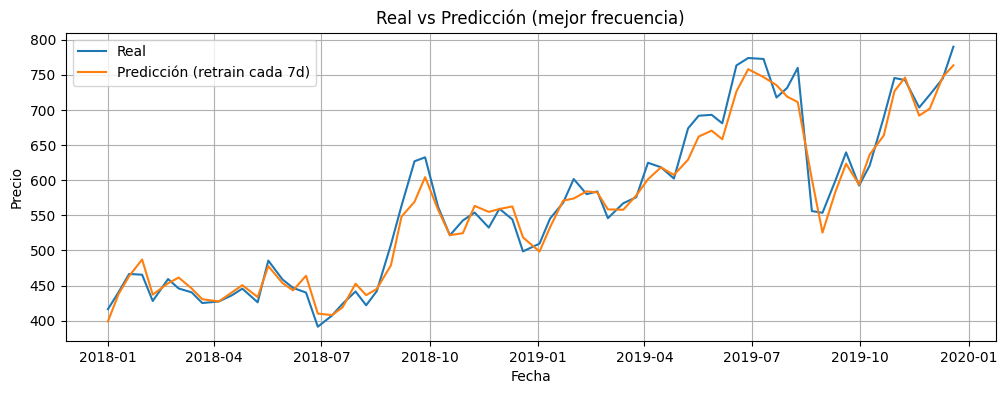


Observaciones:
- Un retrain más frecuente (p.ej. diario) permite actualizar el modelo con la información más reciente pero puede ser costoso en producción.
- Un retrain menos frecuente (semanal/mensual) reduce coste computacional; si los mercados cambian rápidamente puede degradar la precisión.
- Compare también el número de predicciones generadas (n_preds) y la estabilidad de la métrica para seleccionar la frecuencia adecuada.

Limitaciones: esta simulación usa un esquema simple (one-step ahead) y un número reducido de épocas. Para decisiones de producción considere validación más amplia y control de sobreajuste (EarlyStopping, checkpointing).


In [12]:
# Evaluación del impacto de la frecuencia de re-entrenamiento (walk-forward)
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error
from tensorflow.keras import backend as K


def walk_forward_retrain(rnn_class, units, seq_len, retrain_freq, initial_train_frac=0.6,
                         epochs=10, batch_size=32, sliding=False):
    """
    Simula re-entrenamientos cada `retrain_freq` días usando un esquema walk-forward.
    - rnn_class: SimpleRNN/GRU/LSTM class
    - units, seq_len: hiperparámetros del modelo
    - retrain_freq: número de días entre re-entrenamientos (1=diario, 7=semanal, 30=mensual)
    - initial_train_frac: fracción del dataset usada como entrenamiento inicial
    - sliding: si True usa ventana deslizante fija; si False usa ventana expansiva (todos los datos anteriores)

    Retorna: (metrics_dict, df_predictions)
    """
    # Obtener serie con índice temporal
    if 'ypf_data' in globals():
        series = ypf_data['Close'].dropna().astype(float)
    elif 'df' in globals():
        series = df['Close'].dropna().astype(float)
    else:
        raise RuntimeError('No se encontró la serie de precios (ejecute la celda de descarga).')

    n = len(series)
    initial_end = int(n * initial_train_frac)
    preds = []
    trues = []
    pred_dates = []

    t = initial_end
    while t < n:
        # definir ventana de entrenamiento
        if sliding:
            # ventana de tamaño initial_end (fija)
            start_idx = max(0, t - initial_end)
            train_series = series.iloc[start_idx:t]
        else:
            # ventana expansiva: desde inicio hasta t-1
            train_series = series.iloc[:t]

        # construir secuencias
        X_train, y_train = create_sequences(train_series.values.reshape(-1,1), seq_len)
        if len(X_train) == 0:
            t += retrain_freq
            continue

        # escalado ajustado sólo con train
        scaler = StandardScaler()
        X_train_flat = X_train.reshape(-1,1)
        scaler.fit(X_train_flat)
        X_train_s = scaler.transform(X_train_flat).reshape(X_train.shape)
        y_train_s = scaler.transform(y_train.reshape(-1,1)).reshape(-1,1)

        # crear y entrenar modelo
        K.clear_session()
        model = create_rnn_model(units, (seq_len, 1), rnn_class)
        model.fit(X_train_s, y_train_s, epochs=epochs, batch_size=batch_size, shuffle=False, verbose=0)

        # preparar input para predecir el siguiente día t
        if t - seq_len < 0:
            t += retrain_freq
            continue
        x_input = series.values[t-seq_len:t].reshape(1, seq_len, 1)
        x_input_s = scaler.transform(x_input.reshape(-1,1)).reshape(x_input.shape)
        y_pred_s = model.predict(x_input_s)
        y_pred = scaler.inverse_transform(y_pred_s).ravel()[0]
        y_true = series.values[t]

        preds.append(y_pred)
        trues.append(y_true)
        pred_dates.append(series.index[t])

        t += retrain_freq

    metrics = {}
    if len(preds) > 0:
        metrics['mape'] = mean_absolute_percentage_error(trues, preds)
        metrics['mse'] = mean_squared_error(trues, preds)
        metrics['mae'] = mean_absolute_error(trues, preds)
    else:
        metrics['mape'] = np.nan
        metrics['mse'] = np.nan
        metrics['mae'] = np.nan
    metrics['n_preds'] = len(preds)

    df_preds = pd.DataFrame({'Fecha': pred_dates, 'y_true': trues, 'y_pred': preds})

    return metrics, df_preds


# Seleccionar modelo "mejor" a partir de resultados previos si existen
if 'df_res' in globals() and not df_res.empty:
    best = df_res.iloc[0]
    rnn_name = best['rnn_type']
    units_best = int(best['units'])
    seq_best = int(best['seq_len'])
    rnn_class_best = {'SimpleRNN': SimpleRNN, 'GRU': GRU, 'LSTM': LSTM}[rnn_name]
    print(f"Usando mejor modelo detectado: {rnn_name} units={units_best} seq={seq_best}")
else:
    print('No se encontró `df_res` con resultados previos; usando configuración por defecto SimpleRNN(25, seq=40)')
    rnn_class_best = SimpleRNN
    units_best = 25
    seq_best = 40

# Frecuencias a comparar (días)
frecuencias = [1, 7, 30]
summary = []
all_preds = {}
for f in frecuencias:
    print(f"Evaluando re-entrenamiento cada {f} día(s) ...")
    metrics, dfp = walk_forward_retrain(rnn_class_best, units_best, seq_best, retrain_freq=f,
                                        initial_train_frac=0.6, epochs=10, batch_size=32, sliding=False)
    summary.append({'retrain_days': f, 'mape': metrics['mape'], 'mse': metrics['mse'], 'mae': metrics['mae'], 'n_preds': metrics['n_preds']})
    all_preds[f] = dfp

print('\nResumen de frecuencias de re-entrenamiento:')
df_summary = pd.DataFrame(summary).sort_values('mape')
display(df_summary)

# Graficar la mejor frecuencia
valid_rows = df_summary.dropna(subset=['mape'])
if not valid_rows.empty:
    best_f = int(valid_rows.iloc[0]['retrain_days'])
    print(f"Mejor frecuencia por MAPE: {best_f} días")
    df_best = all_preds[best_f]
    plt.figure(figsize=(12,4))
    plt.plot(df_best['Fecha'], df_best['y_true'], label='Real')
    plt.plot(df_best['Fecha'], df_best['y_pred'], label=f'Predicción (retrain cada {best_f}d)')
    plt.title('Real vs Predicción (mejor frecuencia)')
    plt.xlabel('Fecha')
    plt.ylabel('Precio')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print('No se generaron predicciones para las frecuencias seleccionadas.')

print('\nObservaciones:')
print('- Un retrain más frecuente (p.ej. diario) permite actualizar el modelo con la información más reciente pero puede ser costoso en producción.')
print('- Un retrain menos frecuente (semanal/mensual) reduce coste computacional; si los mercados cambian rápidamente puede degradar la precisión.')
print("- Compare también el número de predicciones generadas (n_preds) y la estabilidad de la métrica para seleccionar la frecuencia adecuada.")
print('\nLimitaciones: esta simulación usa un esquema simple (one-step ahead) y un número reducido de épocas. Para decisiones de producción considere validación más amplia y control de sobreajuste (EarlyStopping, checkpointing).')
